### Imports

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from joblib import dump


### Аnalytics

In [105]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [106]:
df = df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

def explore_data(df):

    print("Shape of dataset:", df.shape)
    print("\nData types:\n", df.dtypes)
    print("\nColumns:\n", df.columns)
    print("\nMissing values:\n", df.isnull().sum())
    print("\nUnique values:\n", df.nunique())


    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    if len(numeric_cols) > 0:
        print("\nNumeric Columns:\n", numeric_cols)
        print(df[numeric_cols].describe())
    

    categorical_cols = df.select_dtypes(include='object').columns.tolist()
    if len(categorical_cols) > 0:
        print("\nCategorical Columns:\n", categorical_cols)
        for col in categorical_cols:
            print("\n", col, ":", df[col].unique())
            print(df[col].value_counts(normalize=True))

explore_data(df)

Shape of dataset: (891, 9)

Data types:
 Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
Embarked     object
dtype: object

Columns:
 Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')

Missing values:
 Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Unique values:
 Survived      2
Pclass        3
Sex           2
Age          88
SibSp         7
Parch         7
Fare        248
Cabin       147
Embarked      3
dtype: int64

Numeric Columns:
 ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008 

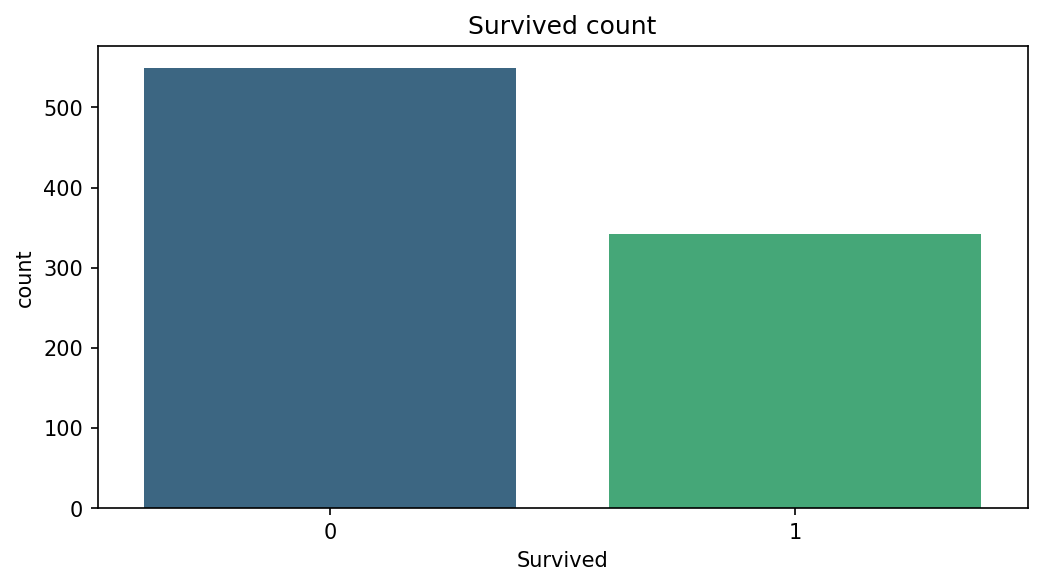

In [107]:
plt.figure(figsize=(8, 4), dpi=150)
plt.title('Survived count')
sns.countplot(data=df, x='Survived', palette='viridis')
plt.show()

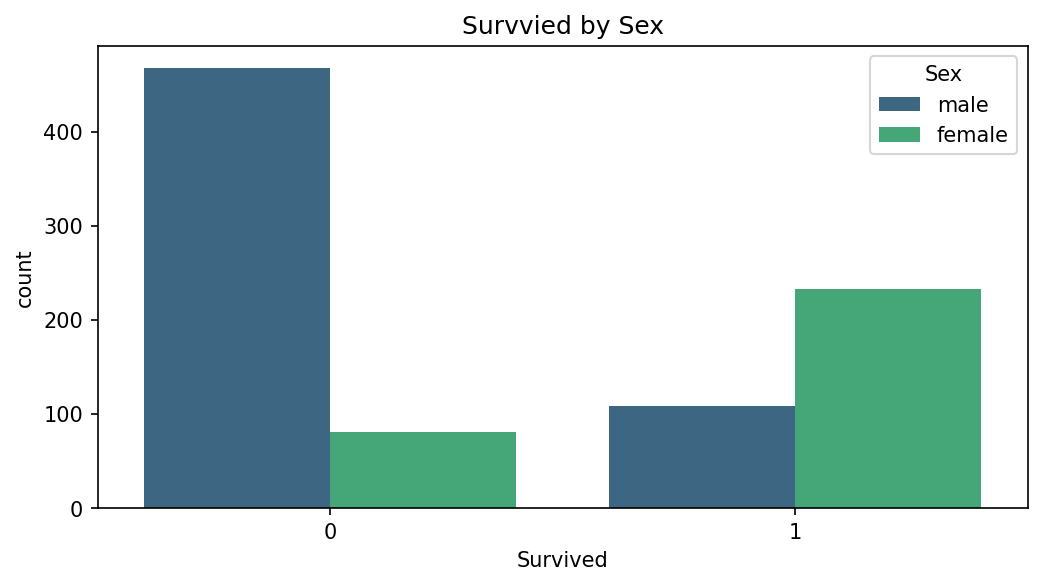

In [108]:
plt.figure(figsize=(8, 4), dpi=150)
plt.title('Survvied by Sex')
sns.countplot(data=df, x='Survived', hue='Sex', palette='viridis')
plt.show()

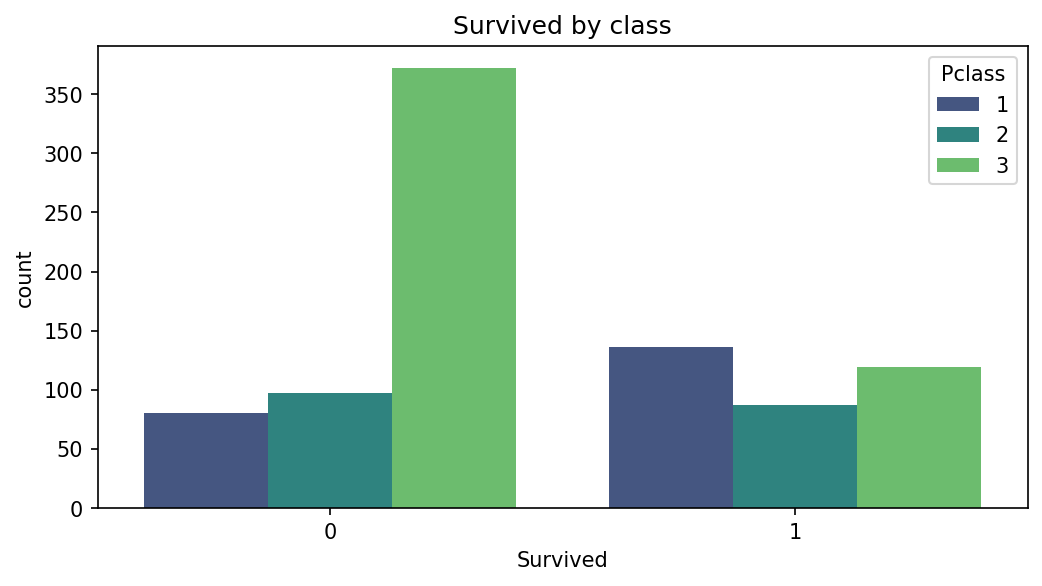

In [109]:
plt.figure(figsize=(8, 4), dpi=150)
plt.title('Survived by class')
sns.countplot(data=df, x='Survived', hue='Pclass', palette='viridis')
plt.show()

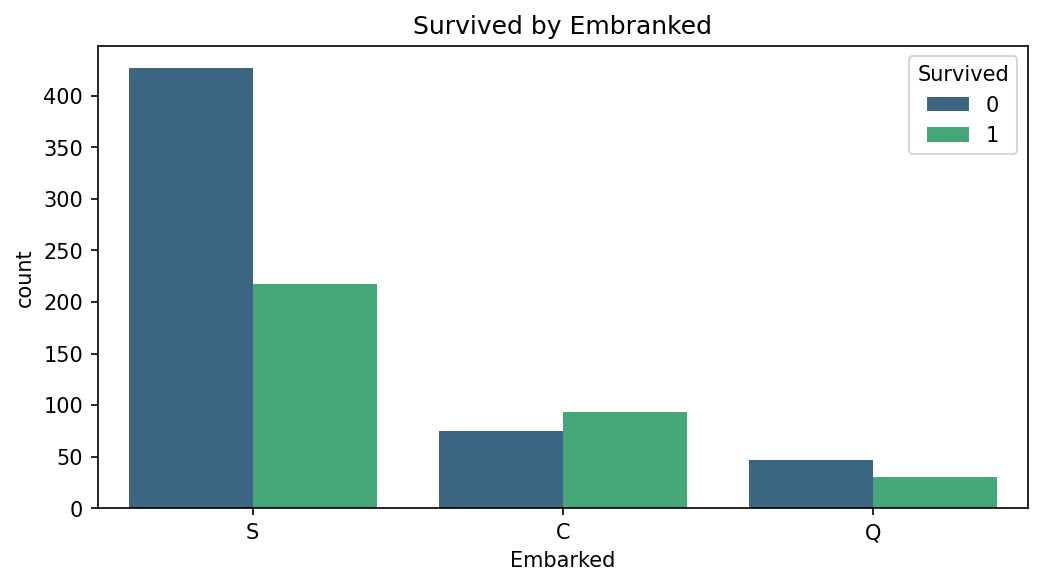

In [110]:
plt.figure(figsize=(8, 4), dpi=150)
plt.title('Survived by Embranked')
sns.countplot(data=df, x='Embarked', hue='Survived', palette='viridis')
plt.show()

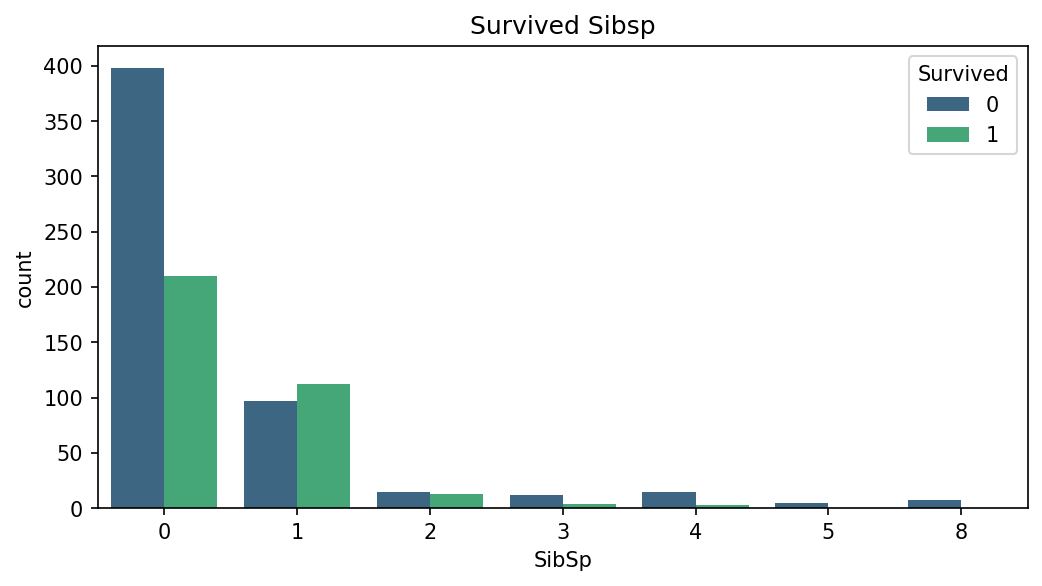

In [111]:
plt.figure(figsize=(8, 4), dpi=150)
plt.title('Survived Sibsp')
sns.countplot(data=df, x='SibSp', hue='Survived', palette='viridis')
plt.show()

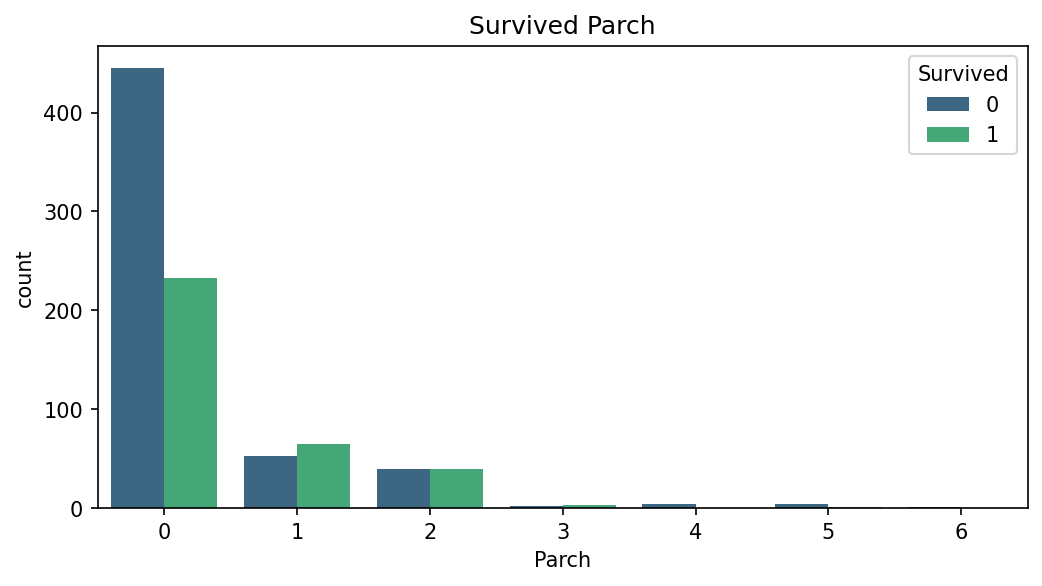

In [112]:
plt.figure(figsize=(8, 4), dpi=150)
plt.title('Survived Parch')
sns.countplot(data=df, x='Parch', hue='Survived', palette='viridis')
plt.show()

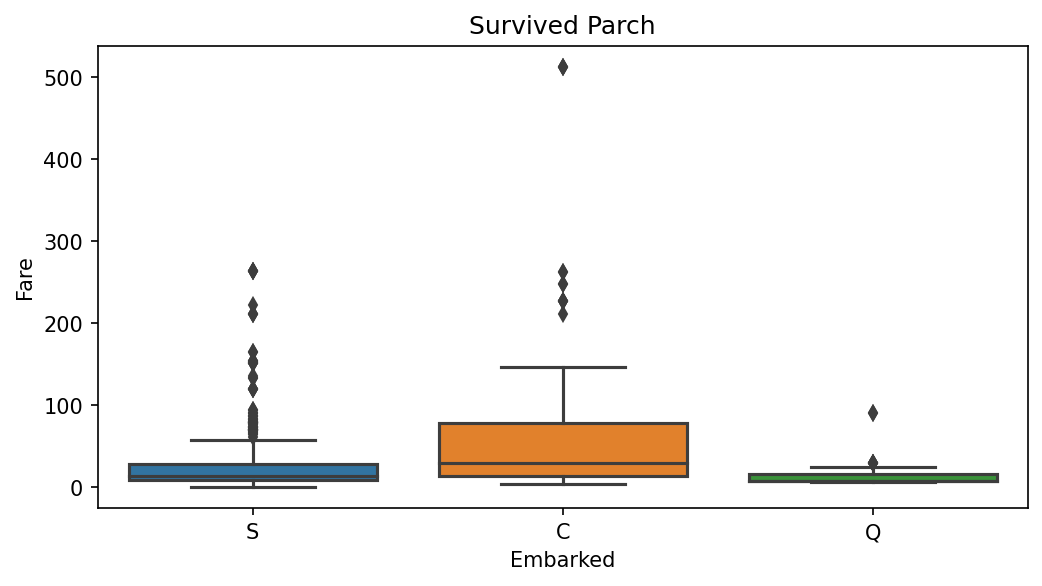

In [113]:
plt.figure(figsize=(8, 4), dpi=150)
plt.title('Survived Parch')
sns.boxplot(data=df, y='Fare', x='Embarked')
plt.show()

In [114]:
print('Average in Fare by Embarked')
S = df[df['Embarked'] == 'S']['Fare']
C = df[df['Embarked'] == 'C']['Fare']
Q = df[df['Embarked'] == 'Q']['Fare']
print(f'S: {np.mean(S)}\nC: {np.mean(C)}\nQ: {np.mean(Q)}')

Average in Fare by Embarked
S: 27.079811801242233
C: 59.95414404761905
Q: 13.276029870129872


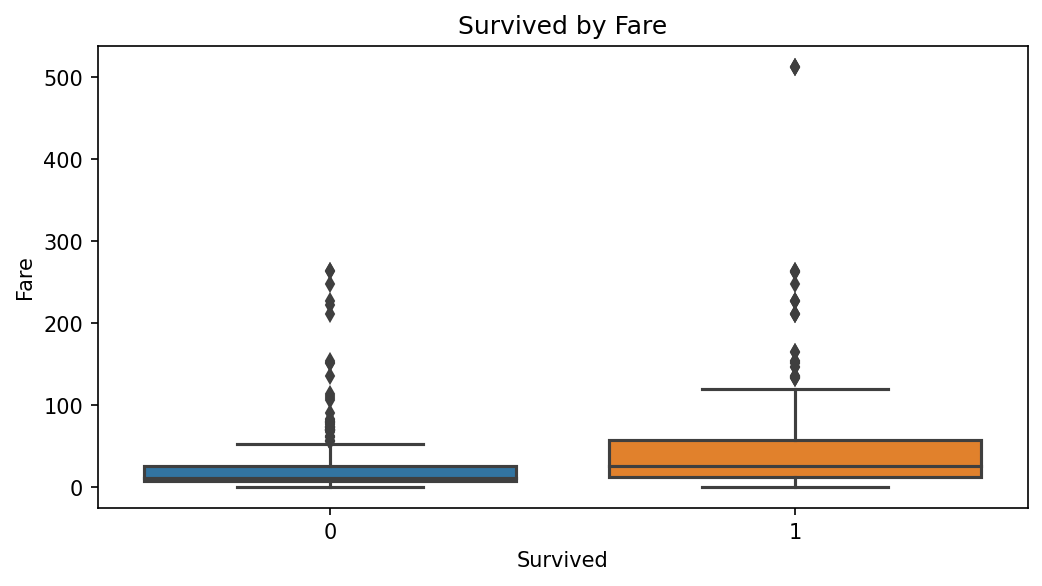

In [115]:
plt.figure(figsize=(8, 4), dpi=150)
plt.title('Survived by Fare')
sns.boxplot(data=df, x='Survived', y='Fare')
plt.show()

In [116]:
df = df.drop(index=[258, 679, 737])  # Need to drop residuals

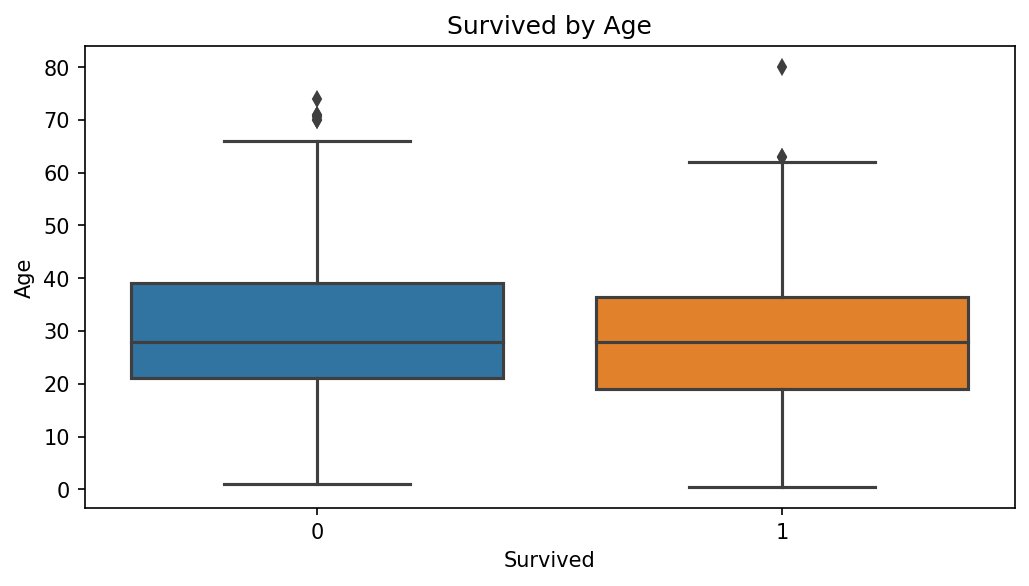

In [117]:
plt.figure(figsize=(8, 4), dpi=150)
plt.title('Survived by Age')
sns.boxplot(data=df, y='Age', x='Survived')
plt.show()

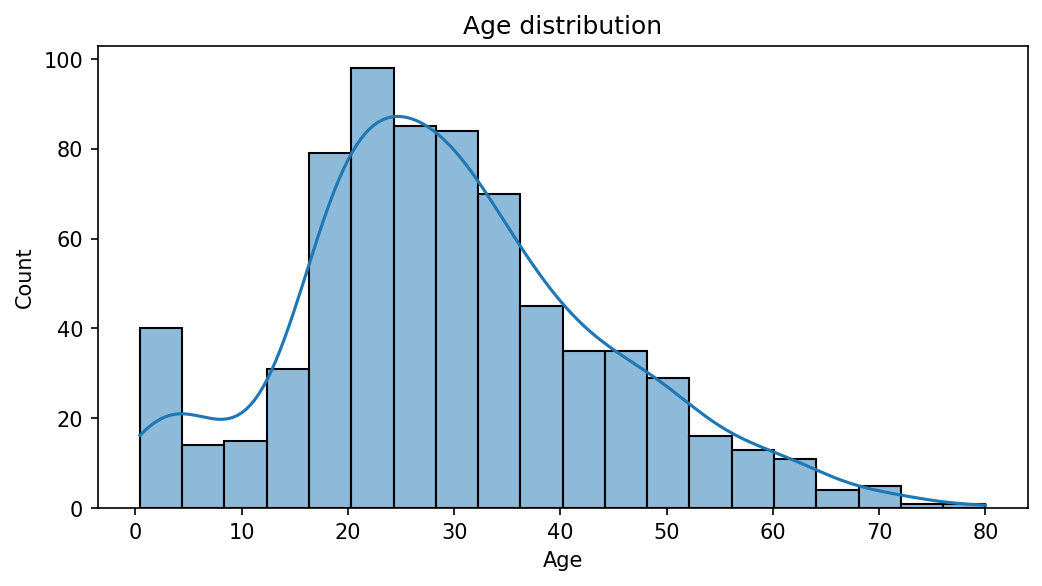

In [118]:
plt.figure(figsize=(8, 4), dpi=150)
plt.title('Age distribution')
sns.histplot(data=df, x='Age', kde=True)
plt.show()

### Missing Values

          n_miss  ratio
Embarked       2   0.23
Age          177  19.93
Cabin        686  77.25


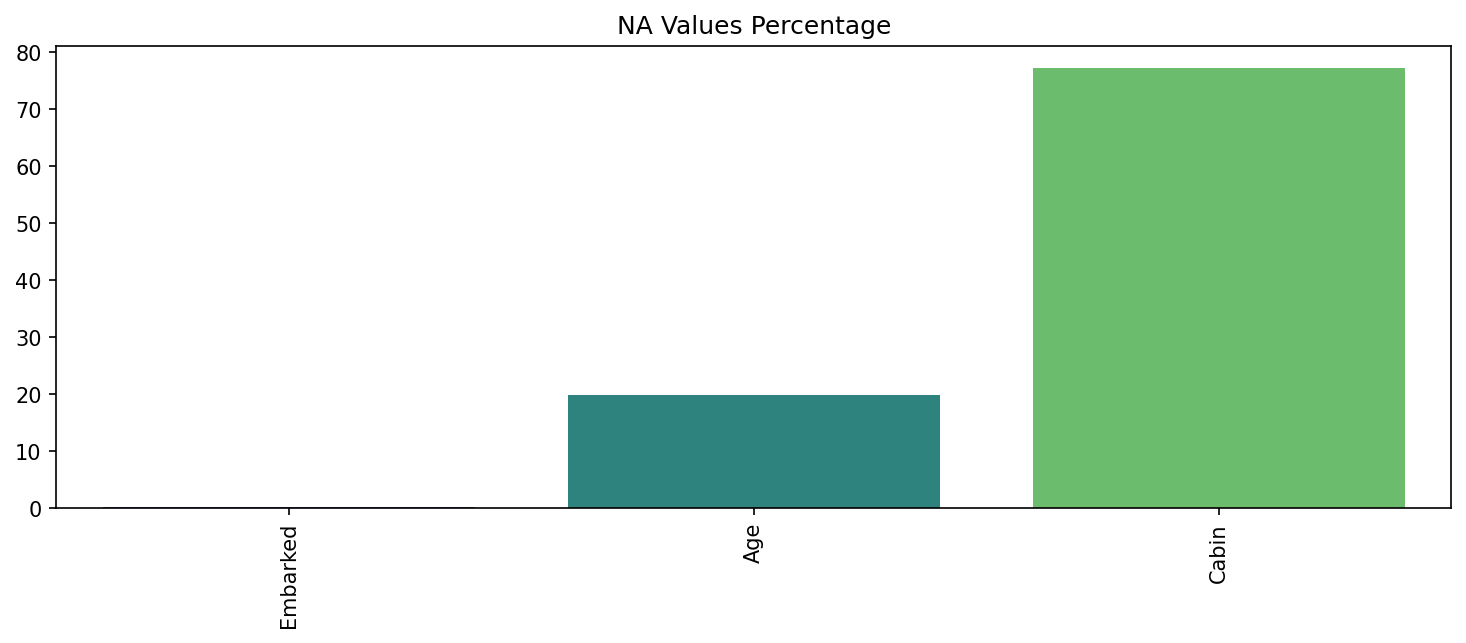

In [119]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=True)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns
    
    plt.figure(figsize=(12, 4), dpi=150)
    plt.title('NA Values Percentage')
    sns.barplot(x=missing_df.index, y=ratio, palette='viridis')
    plt.xticks(rotation=90)
    plt.show()

missing_values_table(df)

In [120]:
df['Age'] = df['Age'].fillna(np.mean(df['Age']))

In [121]:
df = df.drop('Cabin', axis=1)

In [122]:
df[df['Embarked'].isna()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,female,38.0,0,0,80.0,NaN
829,1,1,female,62.0,0,0,80.0,NaN


In [123]:
df.loc[[61, 829]] = df.loc[[61, 829]].fillna('C')
df.loc[[61, 829]]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,female,38.0,0,0,80.0,C
829,1,1,female,62.0,0,0,80.0,C


In [124]:
df.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [125]:
df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
1,1,1,female,38.000000,1,0,71.2833,C
2,1,3,female,26.000000,0,0,7.9250,S
3,1,1,female,35.000000,1,0,53.1000,S
4,0,3,male,35.000000,0,0,8.0500,S
5,0,3,male,29.675345,0,0,8.4583,Q
6,0,1,male,54.000000,0,0,51.8625,S
7,0,3,male,2.000000,3,1,21.0750,S
8,1,3,female,27.000000,0,2,11.1333,S
9,1,2,female,14.000000,1,0,30.0708,C


In [126]:
final_df = pd.get_dummies(df, drop_first=True)

<AxesSubplot: >

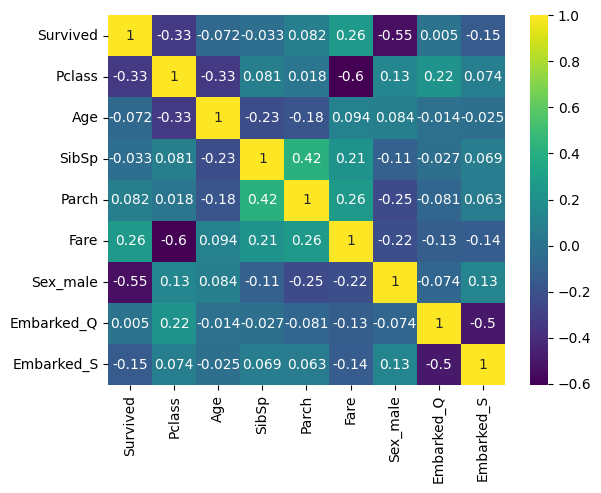

In [127]:
sns.heatmap(final_df.corr(), annot=True, cmap='viridis')

In [128]:
X = final_df.drop('Survived', axis=1)
y = final_df['Survived']
X.to_csv('base_models/X_need_to_scale.csv', index=False)

### Model

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [130]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [131]:
log_model = LogisticRegression(verbose=2, max_iter=10000)

In [132]:
grid_params = {'C': [0.001, 0.01, 0.02, 0.1, 1, 10, 100], 'penalty': ['l2', 'none']}
grid_model = GridSearchCV(log_model, param_grid=grid_params, cv=5, scoring='accuracy')

In [133]:
grid_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000, verbose=2),
             param_grid={'C': [0.001, 0.01, 0.02, 0.1, 1, 10, 100],
                         'penalty': ['l2', 'none']},
             scoring='accuracy')

In [134]:
grid_model.best_estimator_

LogisticRegression(C=0.02, max_iter=10000, verbose=2)

In [135]:
grid_model.best_score_

0.8036

In [136]:
grid_model.best_params_

{'C': 0.02, 'penalty': 'l2'}

In [137]:
pd.DataFrame(grid_model.cv_results_['mean_test_score'])

,0
0,0.639290
1,0.795548
2,0.800387
3,0.795548
4,0.803600
5,0.795548
6,0.797135
7,0.795548
8,0.793935
9,0.795548


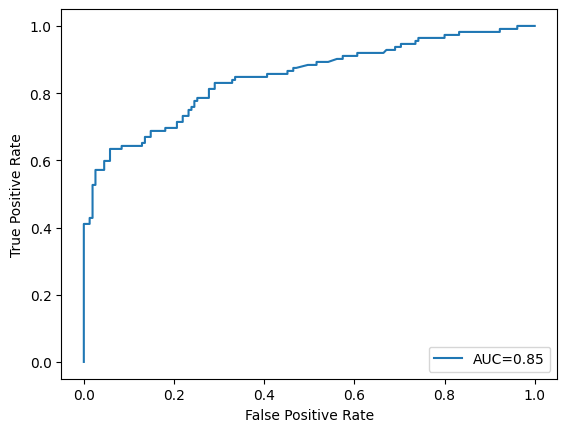

In [138]:
y_pred_proba = grid_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = round(roc_auc_score(y_test, y_pred_proba), 2)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Final Test

In [139]:
y_pred = grid_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7827715355805244

In [140]:
confusion_matrix(y_test, y_pred)

array([[137,  18],
       [ 40,  72]], dtype=int64)

In [141]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.88      0.83       155
           1       0.80      0.64      0.71       112

    accuracy                           0.78       267
   macro avg       0.79      0.76      0.77       267
weighted avg       0.78      0.78      0.78       267



# Using model

In [142]:
log_model = LogisticRegression(max_iter=10000)
grid_params = {'C': [0.001, 0.01, 0.02, 0.1, 1, 10, 100], 'penalty': ['l2', 'none']}
grid_model = GridSearchCV(log_model, param_grid=grid_params, cv=5, scoring='accuracy')
X = scaler.fit_transform(X)

grid_model.fit(X, y)

C:\Users\aga24\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\aga24\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\aga24\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\aga24\AppData\Local\Packages\PythonSoftwareFoundation.Pytho

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.001, 0.01, 0.02, 0.1, 1, 10, 100],
                         'penalty': ['l2', 'none']},
             scoring='accuracy')

In [143]:
grid_model.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [144]:
from joblib import dump
dump(grid_model, 'base_models/titanic_model.joblib')


['base_models/titanic_model.joblib']

# Fare model

In [145]:
final_df = final_df[final_df['Fare']<100]

y1 = final_df['Fare']
X1 = final_df.drop(['Fare', 'Survived'], axis=1) 
y1.max()

93.5

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.1, random_state=101)
X_train.astype(int).to_csv('base_models/X_need_to_fare_scale.csv', index=False)
X_train

,Pclass,Age,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S
216,3,27.000000,0,0,0,0,1
635,2,28.000000,0,0,0,0,1
555,1,62.000000,0,0,1,0,1
357,2,38.000000,0,0,0,0,1
132,3,47.000000,1,0,0,0,1
...,...,...,...,...,...,...,...
77,3,29.675345,0,0,1,0,1
637,2,31.000000,1,1,1,0,1
613,3,29.675345,0,0,1,1,0
359,3,29.675345,0,0,0,1,0


In [147]:
scaler1 = StandardScaler()
scaler1.fit(X_train)
X_train = scaler1.transform(X_train)
X_test = scaler1.transform(X_test)

In [148]:
svc = RandomForestRegressor(random_state=101)
param_grid = {'n_estimators': [10, 20, 25, 50, 70, 100, 150, 200, 250, 300], 'max_features': ['sqrt', 'log2'], 'bootstrap': [True, False]}
grid_fare = GridSearchCV(svc, param_grid=param_grid)
grid_fare.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=101),
             param_grid={'bootstrap': [True, False],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 20, 25, 50, 70, 100, 150, 200,
                                          250, 300]})

In [149]:
grid_fare.best_params_

{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 200}

In [150]:
pred1 = grid_fare.predict(X_test)

In [151]:
RMSE = np.sqrt(mean_squared_error(y_test, pred1))
RMSE

9.929200356890663

In [152]:
np.mean(y1)

22.411942482100233

In [153]:
dump(grid_fare, 'base_models/fare_model.joblib')

['base_models/fare_model.joblib']